In [2]:
!git clone https://github.com/GroupLe/grouple-face-tagger/

Cloning into 'grouple-face-tagger'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 397 (delta 142), reused 326 (delta 79), pack-reused 0
Receiving objects: 100% (397/397), 13.88 MiB | 26.56 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [3]:
!cd grouple-face-tagger && touch __init__.py
!mkdir data

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
import torchvision
import wandb
# import sys
# sys.path.insert(0, "grouple-face-tagger/models/face_detection/")
from snn_model.datasets import TripletPathDataset
from snn_model.model import EmbeddingNet, TripletNet
from snn_model.functions import accuracy
from snn_model.transformations import EmptyTransformation


In [2]:
root = Path('../../processed/')

In [3]:
filecount=0
for dirpath, dirs, files in os.walk(root):
    for filename in files:
        filecount+=1
print(filecount)
print(len(os.listdir(root)))

21862
284


In [4]:
import torchvision.transforms as T

composed = torchvision.transforms.Compose([T.ToTensor(),
                                           T.Resize((128, 128)),
                                           T.RandomChoice((T.ColorJitter(0.1, 0.1, 0.1),
                                                          T.RandomRotation(degrees=(0, 60)),
                                                          EmptyTransformation()))
                                                          ])

100%|██████████| 284/284 [00:56<00:00,  5.05it/s]


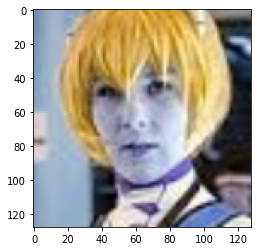

In [5]:
siamse_dataset = TripletPathDataset(Path(root), transform = composed)

pic = siamse_dataset[1][1]
plt.imshow(pic.permute(1, 2, 0))

In [6]:
print(round(len(siamse_dataset)*0.8))
print(int(len(siamse_dataset)*0.2))

siamse_dataset_train, siamse_dataset_test = torch.utils.data.random_split(siamse_dataset,
                                                                         (round(len(siamse_dataset)*0.8),
                                                                          int(len(siamse_dataset)*0.2)))

from torch.utils.data import DataLoader
batch_size = 100
train_dl = DataLoader(siamse_dataset_train, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(siamse_dataset_test, batch_size = batch_size, shuffle = True)

17490
4372


In [10]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
criterion = nn.TripletMarginLoss(margin=2.0, p=2)
optimizer = torch.optim.Adagrad(model.parameters())
# wandb.login(host='wandb.ai' relogin=True)

In [11]:
# wandb.init(project="triplet_siamse_network")

In [12]:
for epoch in range(10):
    print('Epoch', epoch)

    print('train')
    for i, (anchor, positive, negative) in (enumerate(train_dl)):
        optimizer.zero_grad()

        pred = model.forward(anchor, positive, negative)
        pred_anchor, pred_positive, pred_negative = pred
        loss = criterion(pred_anchor, pred_positive, pred_negative)

        loss.backward() #count gradients
        optimizer.step() #update weights

        cur_accuracy = accuracy(pred_anchor, pred_positive, pred_negative)
        print(f'  [{i}/{len(train_dl)}] acc {cur_accuracy} loss {loss}')
#         wandb.log({"train/accuracy": cur_accuracy, "train/loss": output})

#     print('train accuracy: ', mean(train_accuracy_history))
#     print('train loss: ', sum(train_loss_history)/len(train_loss_history))


    print('test')
    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(test_dl):
            pred = model.forward(anchor, positive, negative)
            pred_anchor, pred_positive, pred_negative = pred
            loss = criterion(pred_anchor, pred_positive, pred_negative)
            cur_accuracy = accuracy(pred_anchor, pred_positive, pred_negative)
            print(f'  [{i}/{len(train_dl)}] acc {cur_accuracy} loss {loss}')


Epoch 0
train
  [0/175] acc 0.78 loss 1.7152155637741089
  [1/175] acc 0.7 loss 1.7575160264968872
  [2/175] acc 0.72 loss 1.2280845642089844
  [3/175] acc 0.78 loss 1.416122555732727
  [4/175] acc 0.8 loss 1.283624529838562
  [5/175] acc 0.77 loss 1.3139818906784058
  [6/175] acc 0.72 loss 1.2551556825637817
  [7/175] acc 0.69 loss 2.013338804244995
  [8/175] acc 0.75 loss 1.0635192394256592
  [9/175] acc 0.66 loss 1.4030154943466187
  [10/175] acc 0.86 loss 0.8544390797615051
  [11/175] acc 0.74 loss 1.7689076662063599
  [12/175] acc 0.78 loss 1.266867995262146
  [13/175] acc 0.81 loss 1.1197177171707153
  [14/175] acc 0.71 loss 1.3387829065322876
  [15/175] acc 0.74 loss 1.1199021339416504
  [16/175] acc 0.73 loss 1.3084399700164795
  [17/175] acc 0.76 loss 1.2104995250701904
  [18/175] acc 0.81 loss 0.9518415927886963
  [19/175] acc 0.77 loss 1.6030633449554443
  [20/175] acc 0.81 loss 1.0920534133911133
  [21/175] acc 0.79 loss 1.0184022188186646
  [22/175] acc 0.82 loss 1.1633453

KeyboardInterrupt: 